# Exploring LSTM models 

In this notebook we run lstm models on Infodengue data.

In [78]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import os
#os.chdir("..")

import sys
sys.path.append('../')
from infodenguepredict.models.deeplearning.lstm import *
from infodenguepredict.metrics.metrics import *
#plot_predicted_vs_data, loss_and_metrics, evaluate, calculate_metrics, train_evaluate_model, 
#from infodenguepredict.models.deeplearning.preprocessing import *
#from infodenguepredict.models.deeplearning.lstm import lstm.build_model
#try:
#    from infodenguepredict.models.deeplearning.lstm import *
#except Exception as e:
#    print(e)
#from infodengue import get_temperature_data, get_alerta_table, get_tweet_data, combined_data, get_cluster_data
import pickle
import getpass, os
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import backend as K
from sklearn.metrics import *
import pandas as pd
from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the data

To download the data we follow the instructions in the [README.rst](https://github.com/fccoelho/InfoDenguePredict/blob/master/README.rst) file.

We perform our experiments on data from Rio de Janeiro. Let us first read all our data.

In [39]:
data_cluster = pd.read_csv("./sample_data/3304557_cluster.csv",index_col=0)
data_cluster.head()

,casos_3306206,casos_est_3306206,casos_est_min_3306206,casos_est_max_3306206,p_rt1_3306206,p_inc100k_3306206,temp_min_3306206,temp_max_3306206,umid_min_3306206,pressao_min_3306206,...,casos_3300456,casos_est_3300456,casos_est_min_3300456,casos_est_max_3300456,p_rt1_3300456,p_inc100k_3300456,temp_min_3300456,temp_max_3300456,umid_min_3300456,pressao_min_3300456
2010-01-03,1,1.0,1,1,0.0,2.80725,24.333333,33.000000,42.000000,1009.666667,...,3,3.0,3,3,0.0,0.607114,24.333333,33.000000,42.000000,1009.666667
2010-01-10,0,0.0,0,0,0.0,0.00000,25.428571,34.000000,43.285714,1008.000000,...,6,6.0,6,6,0.0,1.214230,25.428571,34.000000,43.285714,1008.000000
2010-01-17,0,0.0,0,0,0.0,0.00000,24.142857,34.000000,43.857143,1010.285714,...,1,1.0,1,1,0.0,0.202371,24.142857,34.000000,43.857143,1010.285714
2010-01-24,0,0.0,0,0,0.0,0.00000,23.714286,34.285714,39.285714,1009.000000,...,4,4.0,4,4,0.0,0.809486,23.714286,34.285714,39.285714,1009.000000
2010-01-31,0,0.0,0,0,0.0,0.00000,23.857143,33.857143,41.285714,1009.857143,...,9,9.0,9,9,0.0,1.821340,23.857143,33.857143,41.285714,1009.857143


The city of Rio is coded as cluster `3304557`. We can easily filter the dataframe above to get only the data corresponding to this cluster.

In [40]:
data_cluster.tail()

,casos_3306206,casos_est_3306206,casos_est_min_3306206,casos_est_max_3306206,p_rt1_3306206,p_inc100k_3306206,temp_min_3306206,temp_max_3306206,umid_min_3306206,pressao_min_3306206,...,casos_3300456,casos_est_3300456,casos_est_min_3300456,casos_est_max_3300456,p_rt1_3300456,p_inc100k_3300456,temp_min_3300456,temp_max_3300456,umid_min_3300456,pressao_min_3300456
2019-04-14,3,3.0,3,3,0.123280,8.42176,23.428571,25.285714,85.986071,1012.857143,...,4,4.0,4,4,0.015841,0.809486,23.428571,25.285714,85.986071,1012.857143
2019-04-21,3,3.0,3,3,0.173497,8.42176,22.571429,25.571429,76.046814,1011.857143,...,0,0.0,0,0,0.000000,0.000000,22.571429,25.571429,76.046814,1011.857143
2019-04-28,11,12.0,11,13,0.958076,33.68700,23.857143,26.857143,78.433171,1013.428571,...,0,0.0,0,0,0.000000,0.000000,23.857143,26.857143,78.433171,1013.428571
2019-05-05,15,20.0,16,21,0.995579,56.14510,23.142857,25.857143,80.172271,1013.000000,...,0,0.0,0,0,0.000000,0.000000,23.142857,25.857143,80.172271,1013.000000
2019-05-12,8,14.0,10,15,0.734682,39.30160,22.142857,24.857143,77.838957,1014.000000,...,0,0.0,0,0,0.000000,0.000000,22.142857,24.857143,77.838957,1014.000000


In [41]:
cluster_rj = data_cluster[[c for c in data_cluster.columns if "3304557" in c.split("_")]]
print(cluster_rj.shape)
print(cluster_rj.columns)
cluster_rj.head()

(488, 10)
Index(['casos_3304557', 'casos_est_3304557', 'casos_est_min_3304557',
       'casos_est_max_3304557', 'p_rt1_3304557', 'p_inc100k_3304557',
       'temp_min_3304557', 'temp_max_3304557', 'umid_min_3304557',
       'pressao_min_3304557'],
      dtype='object')


,casos_3304557,casos_est_3304557,casos_est_min_3304557,casos_est_max_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
2010-01-03,30,30.0,30,30,0.0,0.461621,24.333333,33.000000,42.000000,1009.666667
2010-01-10,46,46.0,46,46,0.0,0.707819,25.428571,34.000000,43.285714,1008.000000
2010-01-17,30,30.0,30,30,0.0,0.461621,24.142857,34.000000,43.857143,1010.285714
2010-01-24,51,51.0,51,51,0.0,0.784756,23.714286,34.285714,39.285714,1009.000000
2010-01-31,58,58.0,58,58,0.0,0.892467,23.857143,33.857143,41.285714,1009.857143


Our goal is to predict the first column, `casos_3304557` from the columns `p_rt1_3304557`, `p_inc100k_3304557`, `temp_min_3304557`, `temp_max_3304557`, `umid_min_3304557`, `pressao_min_3304557`.

In [42]:
usecols = ['casos_3304557', 'p_rt1_3304557', 'p_inc100k_3304557',
       'temp_min_3304557', 'temp_max_3304557', 'umid_min_3304557',
       'pressao_min_3304557']
data = cluster_rj[usecols]
timestamps = pd.to_datetime(data.index)
data.head()


,casos_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
2010-01-03,30,0.0,0.461621,24.333333,33.000000,42.000000,1009.666667
2010-01-10,46,0.0,0.707819,25.428571,34.000000,43.285714,1008.000000
2010-01-17,30,0.0,0.461621,24.142857,34.000000,43.857143,1010.285714
2010-01-24,51,0.0,0.784756,23.714286,34.285714,39.285714,1009.000000
2010-01-31,58,0.0,0.892467,23.857143,33.857143,41.285714,1009.857143


In [43]:
timestamps

DatetimeIndex(['2010-01-03', '2010-01-10', '2010-01-17', '2010-01-24',
               '2010-01-31', '2010-02-07', '2010-02-14', '2010-02-21',
               '2010-02-28', '2010-03-07',
               ...
               '2019-03-10', '2019-03-17', '2019-03-24', '2019-03-31',
               '2019-04-07', '2019-04-14', '2019-04-21', '2019-04-28',
               '2019-05-05', '2019-05-12'],
              dtype='datetime64[ns]', length=488, freq=None)

Let us plot the features of our dataset.

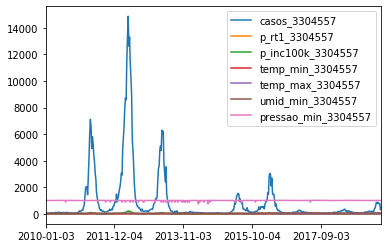

In [44]:
data.plot()

## Normalizing and splitting train/tests sets

In [45]:
### Normalizing data
min_values = np.min(data,axis=0)
max_values = np.max(data,axis=0)
data, _ = normalize_data(data)
data.index=pd.to_datetime(data.index)
data.head()

,casos_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
1970-01-01 00:00:00.000000000,0.002018,0.0,0.002018,0.920721,0.891892,0.488451,0.982712
1970-01-01 00:00:00.000000001,0.003094,0.0,0.003094,0.962162,0.918919,0.503404,0.981090
1970-01-01 00:00:00.000000002,0.002018,0.0,0.002018,0.913514,0.918919,0.510049,0.983315
1970-01-01 00:00:00.000000003,0.003430,0.0,0.003430,0.897297,0.926641,0.456885,0.982063
1970-01-01 00:00:00.000000004,0.003901,0.0,0.003901,0.902703,0.915058,0.480144,0.982898


In [46]:
max_values

casos_3304557          14868.000000
p_rt1_3304557              1.000000
p_inc100k_3304557        228.779000
temp_min_3304557          26.428571
temp_max_3304557          37.000000
umid_min_3304557          85.986071
pressao_min_3304557     1027.428571
dtype: float64

In [47]:
min_values

casos_3304557           17.000000
p_rt1_3304557            0.000000
p_inc100k_3304557        0.261585
temp_min_3304557        14.285714
temp_max_3304557        17.714286
umid_min_3304557        20.428571
pressao_min_3304557    752.714286
dtype: float64

In [48]:
np.min(data,axis=0)

casos_3304557          0.001143
p_rt1_3304557          0.000000
p_inc100k_3304557      0.001143
temp_min_3304557       0.540541
temp_max_3304557       0.478764
umid_min_3304557       0.237580
pressao_min_3304557    0.732620
dtype: float64

In [49]:
np.min(data,axis=0).iloc[0]*max_values.iloc[0]

17.0

In [50]:
data.index = timestamps

In [15]:
data.index

DatetimeIndex(['2010-01-03', '2010-01-10', '2010-01-17', '2010-01-24',
               '2010-01-31', '2010-02-07', '2010-02-14', '2010-02-21',
               '2010-02-28', '2010-03-07',
               ...
               '2019-03-10', '2019-03-17', '2019-03-24', '2019-03-31',
               '2019-04-07', '2019-04-14', '2019-04-21', '2019-04-28',
               '2019-05-05', '2019-05-12'],
              dtype='datetime64[ns]', length=488, freq=None)

In [84]:
predict_n=2
Y_column=0
look_back=10
ratio=0.5
### Splitting train/test sets
X_train, y_train, X_test, y_test = split_data(data, look_back, ratio, predict_n, Y_column)
#timestamps_train = 

234


We are looking back 10 weeks to get our training data:

In [85]:
X_train.shape

(234, 10, 7)

In [86]:
X_test.shape

(243, 10, 7)

In [87]:
y_train.shape

(234, 2)

In [88]:
y_test.shape

(243, 2)

## LSTM model
An LSTM model can be retrieved from `lstm.py`.

In [89]:
hidden=4
features=7
predict_n = 2
look_back=10
batch_size=39
model = build_model(hidden, features, predict_n, look_back, batch_size)

Compilation Time :  0.02746891975402832
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (39, 10, 7)               0         
_________________________________________________________________
lstm_13 (LSTM)               (39, 10, 4)               192       
_________________________________________________________________
dropout_13 (Dropout)         (39, 10, 4)               0         
_________________________________________________________________
lstm_14 (LSTM)               (39, 10, 4)               144       
_________________________________________________________________
dropout_14 (Dropout)         (39, 10, 4)               0         
_________________________________________________________________
lstm_15 (LSTM)               (39, 4)                   144       
_________________________________________________________________
dropout_15 (Dropout)         (39, 4)

### Training model

In [90]:
hist = train(model, X_train, y_train, batch_size=1, epochs=20, geocode=3304557, overwrite=True)

../infodenguepredict/models/deeplearning/lstm.py:115: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  callbacks=[TB_callback, EarlyStopping(patience=15)]


Train on 198 samples, validate on 36 samples
Epoch 1/20
198/198 [==============================] - 10s 49ms/step - loss: 0.0230 - acc: 0.5341 - mean_absolute_percentage_error: 600.2182 - mean_squared_error: 0.0390 - val_loss: 0.0064 - val_acc: 0.4900 - val_mean_absolute_percentage_error: 1646.7830 - val_mean_squared_error: 0.0071
Epoch 2/20
198/198 [==============================] - 11s 55ms/step - loss: 0.0204 - acc: 0.4957 - mean_absolute_percentage_error: 602.0374 - mean_squared_error: 0.0354 - val_loss: 0.0038 - val_acc: 0.4893 - val_mean_absolute_percentage_error: 1084.6437 - val_mean_squared_error: 0.0042
Epoch 3/20
198/198 [==============================] - 7s 33ms/step - loss: 0.0156 - acc: 0.4794 - mean_absolute_percentage_error: 431.9559 - mean_squared_error: 0.0280 - val_loss: 0.0027 - val_acc: 0.4972 - val_mean_absolute_percentage_error: 827.0857 - val_mean_squared_error: 0.0030
Epoch 4/20
198/198 [==============================] - 6s 32ms/step - loss: 0.0123 - acc: 0.4878 

#### Training history

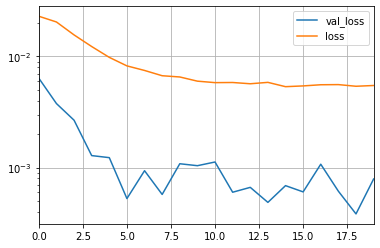

In [91]:
plot_training_history(hist)

#### Plotting predictions 

In [92]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import os
#os.chdir("..")

import sys
sys.path.append('../')
from infodenguepredict.models.deeplearning.lstm import *
from infodenguepredict.metrics.metrics import *
#plot_predicted_vs_data, loss_and_metrics, evaluate, calculate_metrics, train_evaluate_model, 
#from infodenguepredict.models.deeplearning.preprocessing import *
#from infodenguepredict.models.deeplearning.lstm import lstm.build_model
#try:
#    from infodenguepredict.models.deeplearning.lstm import *
#except Exception as e:
#    print(e)
#from infodengue import get_temperature_data, get_alerta_table, get_tweet_data, combined_data, get_cluster_data
import pickle
import getpass, os
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import backend as K
from sklearn.metrics import *
import pandas as pd
from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
#Xdata = np.concatenate((X_train,X_test))
#n_predictions=10
#a = predict_with_dropout(model,Xdata,n_predictions,batch_size=1)
#Xdata.shape

In [95]:
n_shots=10
#batch_size=478
hidden=4
features=7
predict_n=2
look_back=10
batch_size=477
Xdata = np.concatenate((X_train,X_test))
predicted = predict_with_dropout(model,Xdata,n_shots,hidden,features,predict_n,look_back,\
                         batch_size)
Ydata = np.concatenate((y_train,y_test))
index = data.index


Compilation Time :  0.02675604820251465
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (477, 10, 7)              0         
_________________________________________________________________
lstm_19 (LSTM)               (477, 10, 4)              192       
_________________________________________________________________
dropout_19 (Dropout)         (477, 10, 4)              0         
_________________________________________________________________
lstm_20 (LSTM)               (477, 10, 4)              144       
_________________________________________________________________
dropout_20 (Dropout)         (477, 10, 4)              0         
_________________________________________________________________
lstm_21 (LSTM)               (477, 4)                  144       
_________________________________________________________________
dropout_21 (Dropout)         (477, 4


100%|██████████| 10/10 [00:01<00:00,  7.79it/s]

In [96]:
predicted.shape

(10, 477, 2)

### Generating confidence intervals

In [209]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import os
#os.chdir("..")

import sys
sys.path.append('../')
from infodenguepredict.models.deeplearning.lstm import *
from infodenguepredict.metrics.metrics import *
#plot_predicted_vs_data, loss_and_metrics, evaluate, calculate_metrics, train_evaluate_model, 
#from infodenguepredict.models.deeplearning.preprocessing import *
#from infodenguepredict.models.deeplearning.lstm import lstm.build_model
#try:
#    from infodenguepredict.models.deeplearning.lstm import *
#except Exception as e:
#    print(e)
#from infodengue import get_temperature_data, get_alerta_table, get_tweet_data, combined_data, get_cluster_data
import pickle
import getpass, os
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import backend as K
from sklearn.metrics import *
import pandas as pd
from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
len(data.index)

488

In [211]:
predicted.shape

(10, 477, 2)

In [212]:
Ydata.shape

(477, 2)

In [213]:
(predicted[:,0]-predicted[:,1])**2

array([[3.4824733e-03, 4.7960603e-03],
       [0.0000000e+00, 0.0000000e+00],
       [4.8642041e-04, 3.3466058e-04],
       [0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00],
       [1.0085307e-06, 3.9773330e-04],
       [2.1826211e-04, 1.4392423e-04],
       [8.3797611e-05, 7.4094431e-05],
       [6.5555465e-03, 7.4497429e-03],
       [2.3783476e-03, 2.3851763e-03]], dtype=float32)

CPU times: user 31.8 ms, sys: 0 ns, total: 31.8 ms
Wall time: 31.5 ms


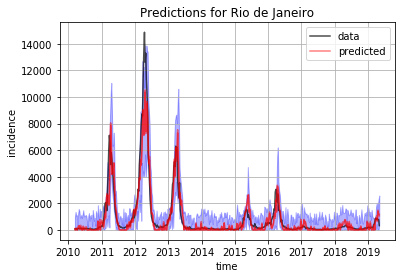

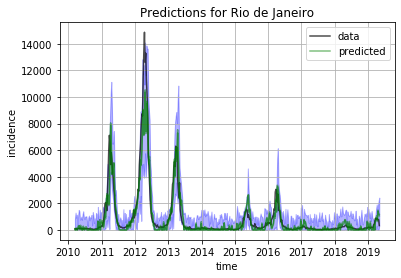

<Figure size 432x288 with 0 Axes>

In [214]:
%%time
#y_pred_train = model.predict(X_train,batch_size=1)
#y_pred_test = model.predict(X_test,batch_size=1)
#predicted = np.concatenate((y_pred_train,y_pred_test))
#Xdata = np.concatenate((X_train,X_test))
#predicted = predict_with_dropout(model,Xdata,n_predictions,batch_size=1)
#Ydata = np.concatenate((y_train,y_test))
#index = data.index
#index = data.index[:]
label="Rio de Janeiro"
predict_n=2
factor=cluster_rj.loc[:,'casos_3304557'].max()
#split_point = int(len(indice)*0.5)
ratio = 0.5
look_back =10
#plot_n = 2
color_preds = ["red","green"]
for plot_n, color_pred in enumerate(color_preds):
    plot_predicted_vs_data(predicted, Ydata, index, label, ratio, factor,look_back,
                          predict_n,plot_n,color_pred)
    plt.figure()

In [215]:
factor

14868

In [216]:
y_pred = np.percentile(predicted, 50, axis=0)

In [217]:
y_pred

array([[ 5.02128154e-04,  7.22194836e-03],
       [-0.00000000e+00, -0.00000000e+00],
       [ 6.91786781e-03,  8.33415985e-03],
       [-0.00000000e+00,  3.03291902e-03],
       [-0.00000000e+00, -0.00000000e+00],
       [ 1.09170079e-02,  1.76739804e-02],
       [ 1.46888047e-02,  2.18352228e-02],
       [ 2.08273344e-02,  2.19901688e-02],
       [ 9.79475677e-04,  4.59128991e-03],
       [ 1.54534765e-02,  2.36148424e-02],
       [ 5.18170372e-03,  4.33922559e-03],
       [-0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00],
       [ 1.32582262e-02,  1.93226896e-02],
       [ 2.80825049e-03,  4.01268527e-03],
       [-0.00000000e+00,  8.31518322e-04],
       [ 6.53419271e-03,  1.41873099e-02],
       [ 7.47338682e-03,  1.53142028e-02],
       [ 3.30774859e-03,  1.59248412e-02],
       [-0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00],
       [-0.

### Computing metrics

In [218]:
y.shape

(477,)

In [219]:
Ydata.shape

(477, 2)

In [220]:
metrics=[]
for t, (y_true, y) in enumerate(zip(Ydata.T,y_pred.T)):
    metrics.append(compute_metrics(y_true,y))
print("Metric scores at t+1: ")
metrics[0]

Metric scores at t+1: 


,explained_variance_score,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score
scores,0.885352,0.020181,0.002137,0.001009,0.008098,0.882655


In [221]:
print("Metric scores at t+2: ")
metrics[1]

Metric scores at t+2: 


,explained_variance_score,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score
scores,0.838758,0.024195,0.002954,0.001497,0.009349,0.83778


### Computing correlations

In [222]:
Xdata.shape

(477, 10, 7)

In [223]:
y_pred.shape

(477, 2)

In [231]:
compute_residue_predictor_correlations(y_true,y_pred, X_predictors, predictors, look_back=10,
                                           predict_n=2,predictor_back=1,as_dataframe=True)

ValueError: operands could not be broadcast together with shapes (477,) (477,2) 

In [232]:
data.columns

Index(['casos_3304557', 'p_rt1_3304557', 'p_inc100k_3304557',
       'temp_min_3304557', 'temp_max_3304557', 'umid_min_3304557',
       'pressao_min_3304557'],
      dtype='object')

In [207]:
X_predictors.shape

(488, 7)

In [239]:
correlations=[]
X_predictors = data.values
predictors = data.columns[1:]
look_back=10
predict_n=2
as_dataframe=True
for t, (y_true, y) in enumerate(zip(Ydata.T,y_pred.T)):
    predictor_back = t
    correlations.append(compute_residue_predictor_correlations(y_true,y, X_predictors, predictors, look_back,
                                           predict_n,predictor_back,as_dataframe))
print("Correlation scores at t+1: ")
correlations[0]

Correlation scores at t+1: 


,p_inc100k_3304557,p_rt1_3304557,pressao_min_3304557,temp_max_3304557,temp_min_3304557,umid_min_3304557
correlations,0.104945,0.636855,-0.055338,-0.003427,0.635851,0.044472


In [238]:
correlations[1]

{'p_rt1_3304557': 0.39016488989084525,
 'p_inc100k_3304557': 0.13151744923754433,
 'temp_min_3304557': 0.38939790474079505,
 'temp_max_3304557': 0.07380375043532028,
 'umid_min_3304557': 0.09773211553427166,
 'pressao_min_3304557': -0.058172798354581806}

In [184]:
predictors = ['casos_3304557', 'p_rt1_3304557', 'p_inc100k_3304557',
       'temp_min_3304557', 'temp_max_3304557', 'umid_min_3304557',
       'pressao_min_3304557']
look_back=7
X_predictors = 
compute_residue_predictor_correlations(Ydata,y_pred, Xdata, predictors, look_back,as_dataframe=True)

SyntaxError: invalid syntax (<ipython-input-184-05dcfa966796>, line 5)

## Nova Iguaçu

Let us now train a model for Nova Iguaçu

In [60]:
os.environ['PSQL_USER']='dengue_ro'
os.environ['PSQL_HOST']='localhost'
os.environ['PSQL_DB']='dengue_ro'
os.environ['PSQL_PASSWORD']=getpass.getpass("Enter the database password: ")

Enter the database password: ········


#### Getting and normalizing  dengue data

In [61]:
geocodes = {"rio": 3304557, "n_iguacu": 3303500}
features = ['casos_', 'p_rt1_', 'p_inc100k_',
       'temp_min_', 'temp_max_', 'umid_min_',
       'pressao_min_']
usecols = [f + str(geocodes["n_iguacu"]) for f in features]
df, _ = get_cluster_data(geocodes["n_iguacu"], clusters=[], data_types=["alerta", "weather"], \
                 cols=None, save=False, doenca='dengue')
data=df.loc[:,usecols]
timestamps=data.index
#data = df[usecols]
### Normalizing data
min_values = np.min(data,axis=0)
max_values = np.max(data,axis=0)
data, _ = normalize_data(data)
data.index=timestamps
print("Shape of data: ", data.shape)
data.head()
#df

Shape of data:  (282, 7)


,casos_3303500,p_rt1_3303500,p_inc100k_3303500,temp_min_3303500,temp_max_3303500,umid_min_3303500,pressao_min_3303500
2012-01-01,0.129338,0.996510,0.129337,0.863720,0.780804,0.715183,0.982919
2012-01-08,0.201893,0.999718,0.201892,0.839779,0.782101,0.645548,0.986736
2012-01-15,0.160883,0.814445,0.160883,0.895028,0.856031,0.535959,0.988271
2012-01-22,0.274448,0.997989,0.274448,0.906077,0.871595,0.537671,0.987434
2012-01-29,0.315457,0.997224,0.315457,0.856354,0.809339,0.611301,0.987154


#### Splitting train/test sets

In [62]:
X_train, y_train, X_test, y_test = split_data(data, look_back=10, ratio=0.75, predict_n=1, Y_column=0)
print("X_train shape: {}\t y_train shape: {}\n".format(X_train.shape,y_train.shape))
print("X_test shape: {}\t y_test shape: {}\n".format(X_test.shape,y_test.shape))

train size:  201
X_train shape: (201, 10, 7)	 y_train shape: (201, 1)

X_test shape: (71, 10, 7)	 y_test shape: (71, 1)



#### Running model

In [63]:
batch_size=67
model = build_model(hidden=4, features=7, predict_n=1, look_back=10, batch_size=batch_size)
hist = train(model, X_train, y_train, batch_size=1, epochs=20, geocode=geocodes["n_iguacu"], overwrite=True)

Compilation Time :  0.024903059005737305
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (67, 10, 7)               0         
_________________________________________________________________
lstm_31 (LSTM)               (67, 10, 4)               192       
_________________________________________________________________
dropout_31 (Dropout)         (67, 10, 4)               0         
_________________________________________________________________
lstm_32 (LSTM)               (67, 10, 4)               144       
_________________________________________________________________
dropout_32 (Dropout)         (67, 10, 4)               0         
_________________________________________________________________
lstm_33 (LSTM)               (67, 4)                   144       
_________________________________________________________________
dropout_33 (Dropout)         (67, 4

/home/rio/geomed/Analysis/lstm.py:173: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  callbacks=[TB_callback, es, cp]


Train on 170 samples, validate on 31 samples
Epoch 1/20
170/170 [==============================] - 8s 46ms/step - loss: 0.0299 - acc: 0.0059 - mean_absolute_percentage_error: 790620.7878 - mean_squared_error: 0.0529 - val_loss: 0.0108 - val_acc: 0.0000e+00 - val_mean_absolute_percentage_error: 268.6704 - val_mean_squared_error: 0.0147
Epoch 2/20
170/170 [==============================] - 5s 32ms/step - loss: 0.0255 - acc: 0.0059 - mean_absolute_percentage_error: 547584.9587 - mean_squared_error: 0.0460 - val_loss: 0.0101 - val_acc: 0.0000e+00 - val_mean_absolute_percentage_error: 159.8642 - val_mean_squared_error: 0.0141
Epoch 3/20
170/170 [==============================] - 6s 37ms/step - loss: 0.0186 - acc: 0.0059 - mean_absolute_percentage_error: 247072.2046 - mean_squared_error: 0.0349 - val_loss: 0.0105 - val_acc: 0.0000e+00 - val_mean_absolute_percentage_error: 168.2371 - val_mean_squared_error: 0.0151
Epoch 4/20
170/170 [==============================] - 4s 24ms/step - loss: 0.01

#### Plotting results 
Note that we reload and recompile the trained model.

Compilation Time :  0.02573227882385254
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (1, 10, 7)                0         
_________________________________________________________________
lstm_40 (LSTM)               (1, 10, 4)                192       
_________________________________________________________________
dropout_40 (Dropout)         (1, 10, 4)                0         
_________________________________________________________________
lstm_41 (LSTM)               (1, 10, 4)                144       
_________________________________________________________________
dropout_41 (Dropout)         (1, 10, 4)                0         
_________________________________________________________________
lstm_42 (LSTM)               (1, 4)                    144       
_________________________________________________________________
dropout_42 (Dropout)         (1, 4) 

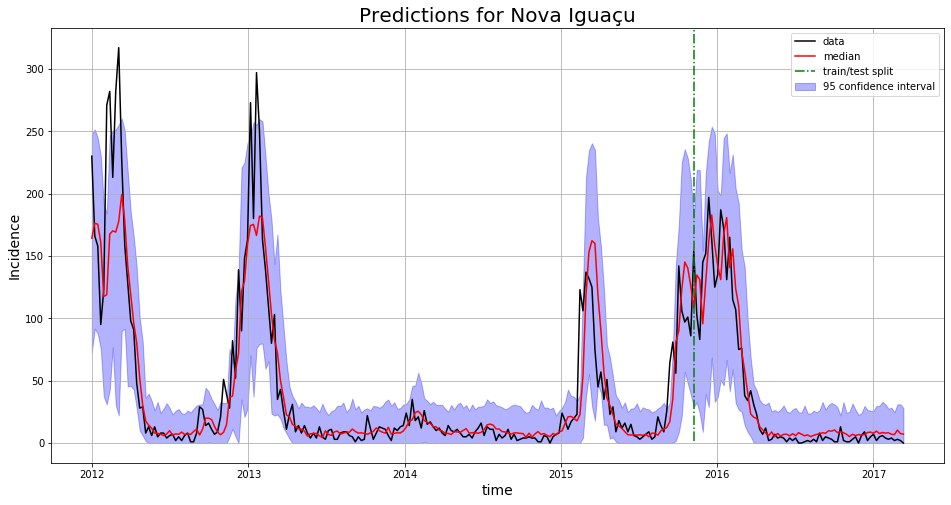

In [68]:
### formatting data and loading model
X, y = np.concatenate((X_train,X_test), axis=0), np.concatenate((y_train,y_test),axis=0)*max_values.iloc[0]

timestamps = data.index[:len(X)]
predictions = make_predictions_batch(X, model, hidden=4, features=7, predict_n = 1, look_back=10,\
                                          batch_size=1,n_pred = 100)*max_values.iloc[0]

### Plotting
plot="median"
confidence=95
data_kw={"label": "data","color":"black"}
pred_kw = {"color":"red"}
fill_kw={"color":"blue","alpha":0.3,"label": "{} confidence interval".format(confidence)}
title_kw={"label": "Predictions for Nova Iguaçu","fontsize":20}
xlabel_kw = {"xlabel": "time","fontsize":14}
ylabel_kw={"ylabel":"Incidence","fontsize":14}
axvline_kw={"x": timestamps[len(X_train)], "linestyle": "dashdot", "ymin":0.05,"ymax":1, "color": "g", "label":"train/test split"}
grid_params={}

fig, ax = plt.subplots(figsize=(16,8))
plot_quantiles(ax,timestamps, predictions[:,:,0],y[:,0],plot,confidence,data_kw,pred_kw,fill_kw,\
               title_kw,xlabel_kw,ylabel_kw,axvline_kw)
### saving figure
fig.savefig("../figures/LSTM_{}_dropout.png".format(geocodes["n_iguacu"]))

In [ ]:
y = np.array([1,2])
x = np.array([[1,2],[]])